In [189]:
import configparser
from pathlib import Path

config = configparser.ConfigParser()
config.read('../../../data/config/config.cfg')

phenopackets_out_dir = ('..' / Path(config.get('Paths', 'phenopackets_out'))).resolve()

phenopackets_out_dir

WindowsPath('C:/Users/Surface/OneDrive/Documents/DataSpell/ERKER2Phenopackets/ERKER2Phenopackets/data/out/phenopackets')

# read in data from phenopackets

In [190]:
from ERKER2Phenopackets.src.utils.io import read_files

example_phenopackets_dir = phenopackets_out_dir / 'example-phenopackets-from-synthetic-data'
pps = read_files(example_phenopackets_dir)

# convert phenopackets to dataframe
Necessary fields:
- id
- zygosity
- cHGVS mutation
- Obsesity Class and timestamp

In [191]:
from typing import Tuple, Any
from phenopackets import Phenopacket

sex_map = {0: 'unknown', 1: 'female', 2: 'male', 3: 'other'}

def extract_phenotype(phenotypic_features, i) -> Tuple[str, str, bool, int]:
    phenotypic_features = phenotypic_features[i]
    obesity_class_hpo = phenotypic_features.type.id
    obesity_class = phenotypic_features.type.label
    excluded = phenotypic_features.excluded
    onset = phenotypic_features.onset.timestamp.ToSeconds()
    return obesity_class_hpo, obesity_class, excluded, onset

def extract_fields(phenopacket: Phenopacket) -> tuple[
                                                    Any, Any, Any, Any, Any, Any, Any, Any, Any, Any, Any, Any, Any, Any, Any, Any, Any] | None:
    pp_id = int(phenopacket.id)
    dob = phenopacket.subject.date_of_birth.ToSeconds()
    sex = sex_map[phenopacket.subject.sex]
    
    try:
        variation_descriptor = phenopacket.interpretations[0].diagnosis.genomic_interpretations[0].variant_interpretation.variation_descriptor
        
        c_hgvs = variation_descriptor.expressions[1].value
        zygosity = variation_descriptor.allelic_state.label
    except IndexError:
        return None
    
    phenotypic_features = phenopacket.phenotypic_features
    obesity_class_hpo0, obesity_class0, excluded0, onset0 = None, None, None, None
    obesity_class_hpo1, obesity_class1, excluded1, onset1 = None, None, None, None
    obesity_class_hpo2, obesity_class2, excluded2, onset2 = None, None, None, None
    
    try:
        obesity_class_hpo0, obesity_class0, excluded0, onset0 = extract_phenotype(phenotypic_features, 0)

        try:
            obesity_class_hpo1, obesity_class1, excluded1, onset1 = extract_phenotype(phenotypic_features, 1)

            try:
                obesity_class_hpo2, obesity_class2, excluded2, onset2 = extract_phenotype(phenotypic_features, 2)
            except IndexError:
                pass
        except IndexError:
            pass
    except IndexError:
        return None
    return pp_id, dob, sex, zygosity, c_hgvs, obesity_class_hpo0, obesity_class0, excluded0, onset0, obesity_class_hpo1, obesity_class1, excluded1, onset1, obesity_class_hpo2, obesity_class2, excluded2, onset2

In [192]:
phenopacket = pps[0]
variation_descriptor = phenopacket.interpretations[0].diagnosis.genomic_interpretations[0].variant_interpretation

In [193]:
for pp in pps:
    print(extract_fields(pp))

(0, 946684800, 'female', 'heterozygous', 'NM_005912.3:c.181G>T', 'HP:0001513', 'Obesity', True, 708652800, None, None, None, None, None, None, None, None)
(1, 915148800, 'female', 'heterozygous', 'NM_005912.3:c.307G>A', 'HP:0001513', 'Obesity', True, 1254268800, 'HP:0001513', 'Obesity', False, 967507200, None, None, None, None)
None
None
(12, 757382400, 'male', 'heterozygous', 'NM_005912.3:c.307G>A', 'HP:0001513', 'Obesity', False, 1118793600, 'HP:0025500', 'Class II obesity', False, 1267056000, None, None, None, None)
(13, 757382400, 'male', 'heterozygous', 'NM_005912.3:c.307G>A', 'HP:0001513', 'Obesity', True, 1234051200, 'HP:0001507', 'Growth abnormality', True, 985219200, 'HP:0001507', 'Growth abnormality', False, 876528000)
None
None
None
(17, 1072915200, 'female', 'homozygous', 'NM_005912.3:c.253A>G', 'HP:0025500', 'Class II obesity', True, 638409600, None, None, None, None, None, None, None, None)
(18, 1136073600, 'female', 'heterozygous', 'NM_005912.3:c.508A>G', 'HP:0001513', '

In [194]:
import polars as pl

data = list(filter(lambda x: x is not None, map(extract_fields, pps)))

data, len(data)

([(0,
   946684800,
   'female',
   'heterozygous',
   'NM_005912.3:c.181G>T',
   'HP:0001513',
   'Obesity',
   True,
   708652800,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None),
  (1,
   915148800,
   'female',
   'heterozygous',
   'NM_005912.3:c.307G>A',
   'HP:0001513',
   'Obesity',
   True,
   1254268800,
   'HP:0001513',
   'Obesity',
   False,
   967507200,
   None,
   None,
   None,
   None),
  (12,
   757382400,
   'male',
   'heterozygous',
   'NM_005912.3:c.307G>A',
   'HP:0001513',
   'Obesity',
   False,
   1118793600,
   'HP:0025500',
   'Class II obesity',
   False,
   1267056000,
   None,
   None,
   None,
   None),
  (13,
   757382400,
   'male',
   'heterozygous',
   'NM_005912.3:c.307G>A',
   'HP:0001513',
   'Obesity',
   True,
   1234051200,
   'HP:0001507',
   'Growth abnormality',
   True,
   985219200,
   'HP:0001507',
   'Growth abnormality',
   False,
   876528000),
  (17,
   1072915200,
   'female',
   'homozygous',
   'NM_005912.3

In [195]:
columns = ['id', 'date_of_birth', 'sex', 'zygosity', 'c_hgvs', 'obesity_class_hpo0', 'obesity_class0', 'phenotype_refuted0', 'onset0', 'obesity_class_hpo1', 'obesity_class1', 'phenotype_refuted1', 'onset1', 'obesity_class_hpo2', 'obesity_class2', 'phenotype_refuted2', 'onset2']
transposed_data = list(zip(*data))

df = pl.DataFrame({col: transposed_data[i] for i, col in enumerate(columns)})

In [196]:
df.head()

id,date_of_birth,sex,zygosity,c_hgvs,obesity_class_hpo0,obesity_class0,phenotype_refuted0,onset0,obesity_class_hpo1,obesity_class1,phenotype_refuted1,onset1,obesity_class_hpo2,obesity_class2,phenotype_refuted2,onset2
i64,i64,str,str,str,str,str,bool,i64,str,str,bool,i64,str,str,bool,i64
0,946684800,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,708652800,null,null,null,null,null,null,null,null
1,915148800,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,1254268800,"""HP:0001513""","""Obesity""",false,967507200,null,null,null,null
12,757382400,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",false,1118793600,"""HP:0025500""","""Class II obesi…",false,1267056000,null,null,null,null
13,757382400,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,1234051200,"""HP:0001507""","""Growth abnorma…",true,985219200,"""HP:0001507""","""Growth abnorma…",false,876528000
17,1072915200,"""female""","""homozygous""","""NM_005912.3:c.…","""HP:0025500""","""Class II obesi…",true,638409600,null,null,null,null,null,null,null,null


# Data Cleaning

There is only one person with an unspecified zygosity, so we can drop this person.

In [197]:
df = df.filter(df['zygosity'] != 'unspecified zygosity')

In [198]:
df.columns[0]

'id'

# Preprocessing

Order dataframe by descending number of same c_hgvs mutations

In [199]:
from typing import Callable

def c_hgvs_occurences(df: pl.DataFrame) -> pl.DataFrame:
    return  df.join(other=df.groupby('c_hgvs').agg(pl.count('c_hgvs').alias('count')).select(['c_hgvs','count']), on='c_hgvs', how='inner').select(['count'])
    


def sort_by_method(df: pl.DataFrame, method: Callable[[pl.DataFrame],Any], descending: bool = True) -> pl.DataFrame:
    """Sorts a DataFrame by a given method.
    
    The method must take the dataframe as input and return a new dataframe with only the column to sort by.
    """
    df_new_col = method(df)
    new_col = df_new_col[df_new_col.columns[0]]

    df = df.with_columns(new_col___123=pl.Series(new_col))
    
    sorted_df = df.sort('new_col___123', descending=descending)
    
    return sorted_df.drop('new_col___123')

df = sort_by_method(df, c_hgvs_occurences)

In [200]:
# correct value of refuted columns to match phenotype: only Obesity has refuted true these are our negatives
df = df.with_columns(
    phenotype_refuted0=df['obesity_class0'] == 'Obesity',
    phenotype_refuted1=df['obesity_class1'] == 'Obesity',
    phenotype_refuted2=df['obesity_class2'] == 'Obesity',
)

In [201]:
# todo: growth abnormality: not recorded phenotype -> replace null
growth_abnormality = 'Growth abnormality'
growth_abnormality_hpo = 'HP:0001507'

df = replace_value(df, 'obesity_class_hpo0', growth_abnormality_hpo, None)
df = replace_value(df, 'obesity_class_hpo1', growth_abnormality_hpo, None)
df = replace_value(df, 'obesity_class_hpo2', growth_abnormality_hpo, None)

df = replace_value(df, 'obesity_class0', growth_abnormality, None)
df = replace_value(df, 'obesity_class1', growth_abnormality, None)
df = replace_value(df, 'obesity_class2', growth_abnormality, None)

In [202]:
# todo: form new column for obesity class: 
# 0: Obesity refuted
# 1: Overweight
# 2: Class I Obesity (HPO)
# 3: Class II Obesity (HPO)
# 4: Class III Obesity (HPO)

In [203]:
df.head(50)

id,date_of_birth,sex,zygosity,c_hgvs,obesity_class_hpo0,obesity_class0,phenotype_refuted0,onset0,obesity_class_hpo1,obesity_class1,phenotype_refuted1,onset1,obesity_class_hpo2,obesity_class2,phenotype_refuted2,onset2
i64,i64,str,str,str,str,str,bool,i64,str,str,bool,i64,str,str,bool,i64
1,915148800,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,1254268800,"""HP:0001513""","""Obesity""",true,967507200,null,null,null,null
12,757382400,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,1118793600,"""HP:0025500""","""Class II obesi…",false,1267056000,null,null,null,null
13,757382400,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,1234051200,"""HP:0001507""","""Growth abnorma…",false,985219200,"""HP:0001507""","""Growth abnorma…",false,876528000
20,1072915200,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,872208000,"""HP:0025499""","""Class I obesit…",false,674524800,"""HP:0001507""","""Growth abnorma…",false,1037750400
23,1293840000,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,766368000,"""HP:0001513""","""Obesity""",true,669772800,"""HP:0001507""","""Growth abnorma…",false,764467200
32,1420070400,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,749174400,"""HP:0001507""","""Growth abnorma…",false,719625600,null,null,null,null
37,1072915200,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,916185600,"""HP:0025499""","""Class I obesit…",false,903744000,"""HP:0001513""","""Obesity""",true,833414400
38,978307200,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,843609600,"""HP:0001507""","""Growth abnorma…",false,1010793600,null,null,null,null
44,1009843200,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,760665600,"""HP:0001507""","""Growth abnorma…",false,1265068800,"""HP:0001507""","""Growth abnorma…",false,822960000


Overweight, Class I-III Obesity: excluded false
if excluded (refuted) true -> BMI in normal range

only Obesity has refuted true these are our negatives

growth abnormality: not recorded phenotype -> drop rows

# Questions
## Descriptive Statistics
1. How is the split of zygosity? Distribution of sex?
2. Distribution of c_hgvs mutations?
3. What if we split the distribution of c_hgvs mutations by zygosity?
4. Distribution of obesity classes?
5. What if we split the distribution of obesity classes by zygosity?
6. What if we split the distribution of obesity classes by c_hgvs mutation?
7. What if we split the distribution of obesity classes by c_hgvs mutation and zygosity?
8. What if we split by sex?
9. How long does it take for a person to develop the different obesity classes based on their mutation?

## Predictive Statistics
1. What is the probability of a person with a certain c_hgvs mutation to develop a certain obesity class?
2. Prediction model of obesity class based on c_hgvs mutation and zygosity

In [204]:
import matplotlib.pyplot as plt
import numpy as np
from ERKER2Phenopackets.src.utils.polars_utils import barchart, barchart_3d, barchart_subplot, barchart_relative_distribution, barchart_relative_distribution_subplot, piechart_subplot, piechart

figsize = (20, 15)

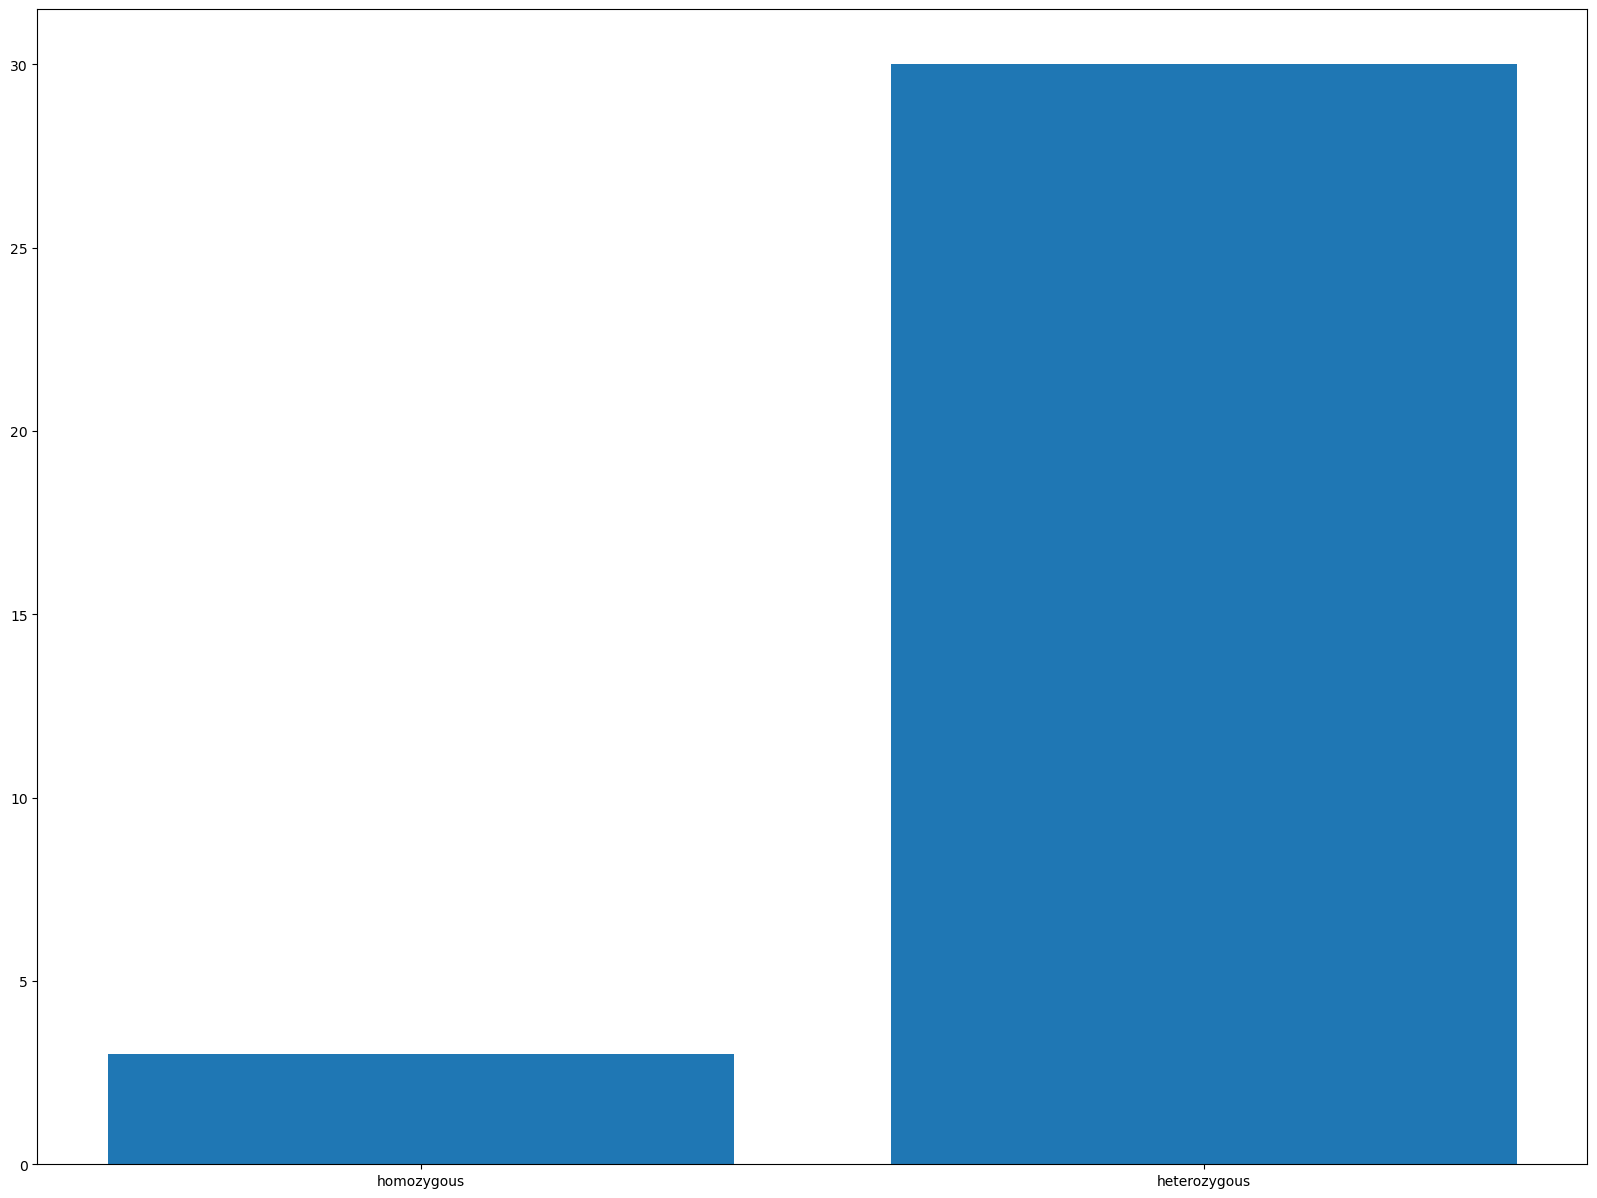

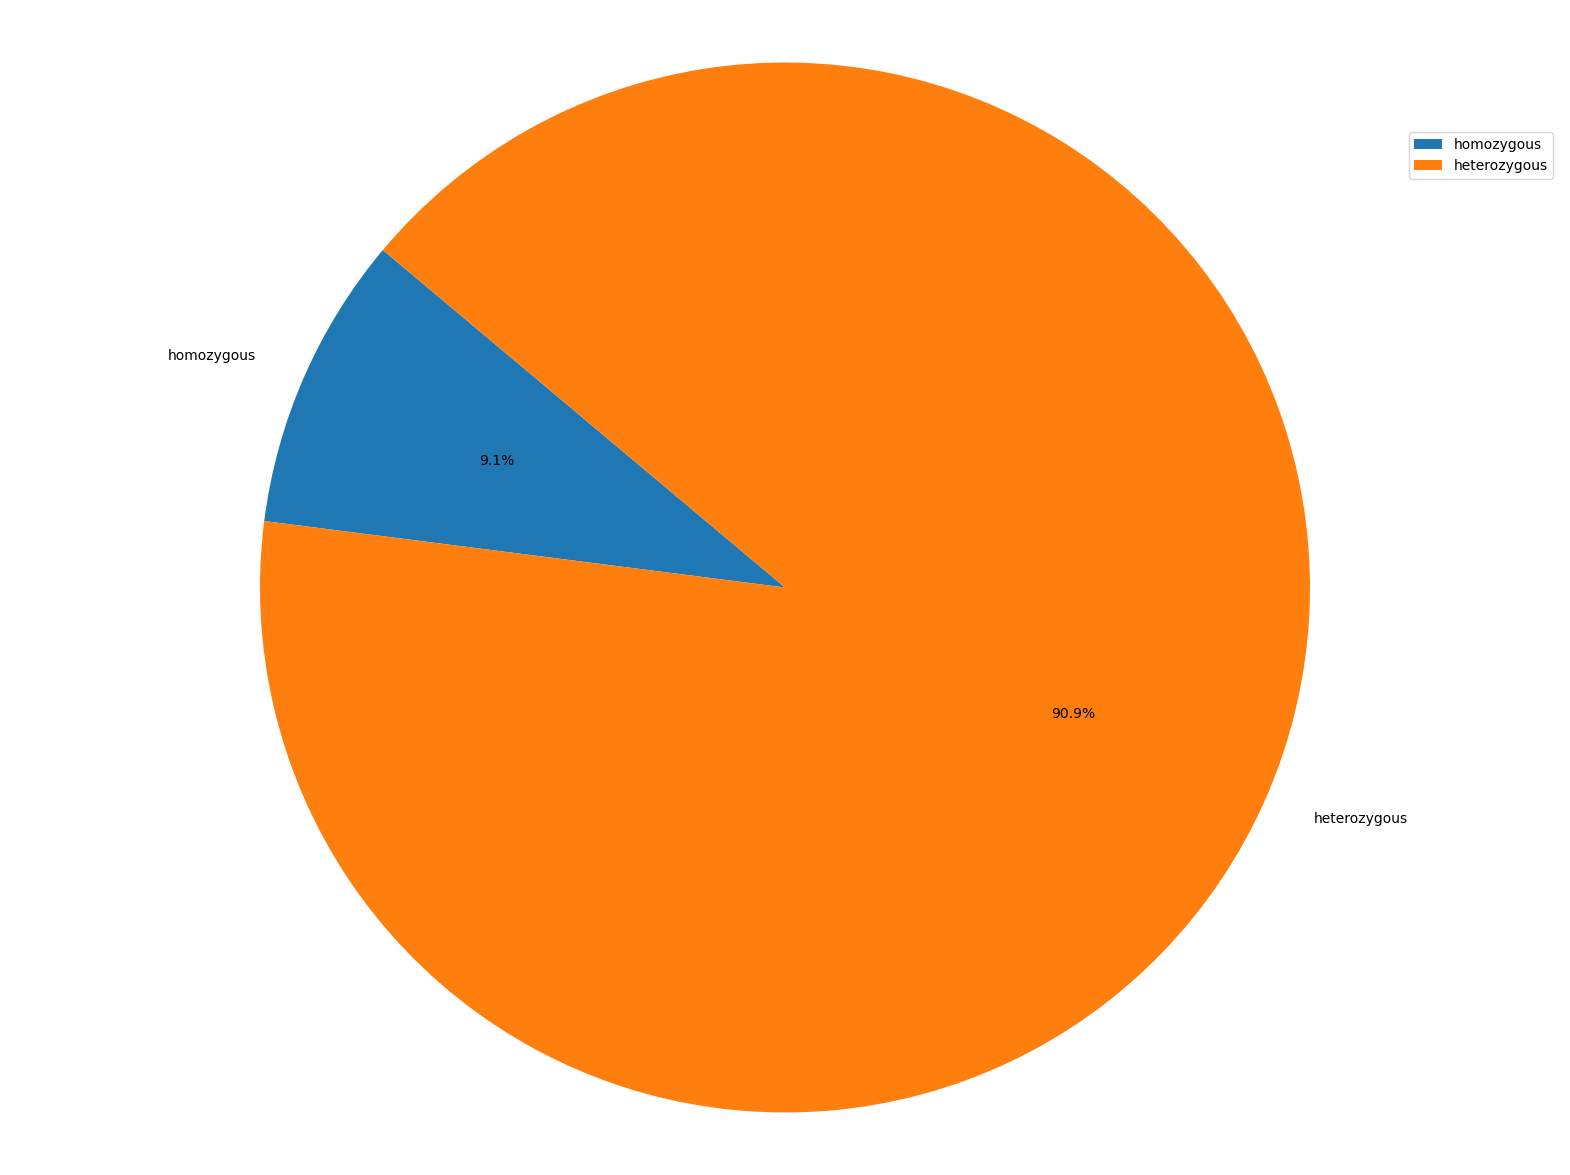

zygosity,count
str,u32
"""homozygous""",3
"""heterozygous""",30


In [205]:
# Descriptive Statistics
# 1. How is the split of zygosity?
grouped_by_zygosity = df.groupby('zygosity').count()
num_zygosity = grouped_by_zygosity.height

barchart(grouped_by_zygosity['zygosity'], grouped_by_zygosity['count'], figsize=figsize)
piechart(grouped_by_zygosity['zygosity'], grouped_by_zygosity['count'], figsize=figsize)

grouped_by_zygosity.head()

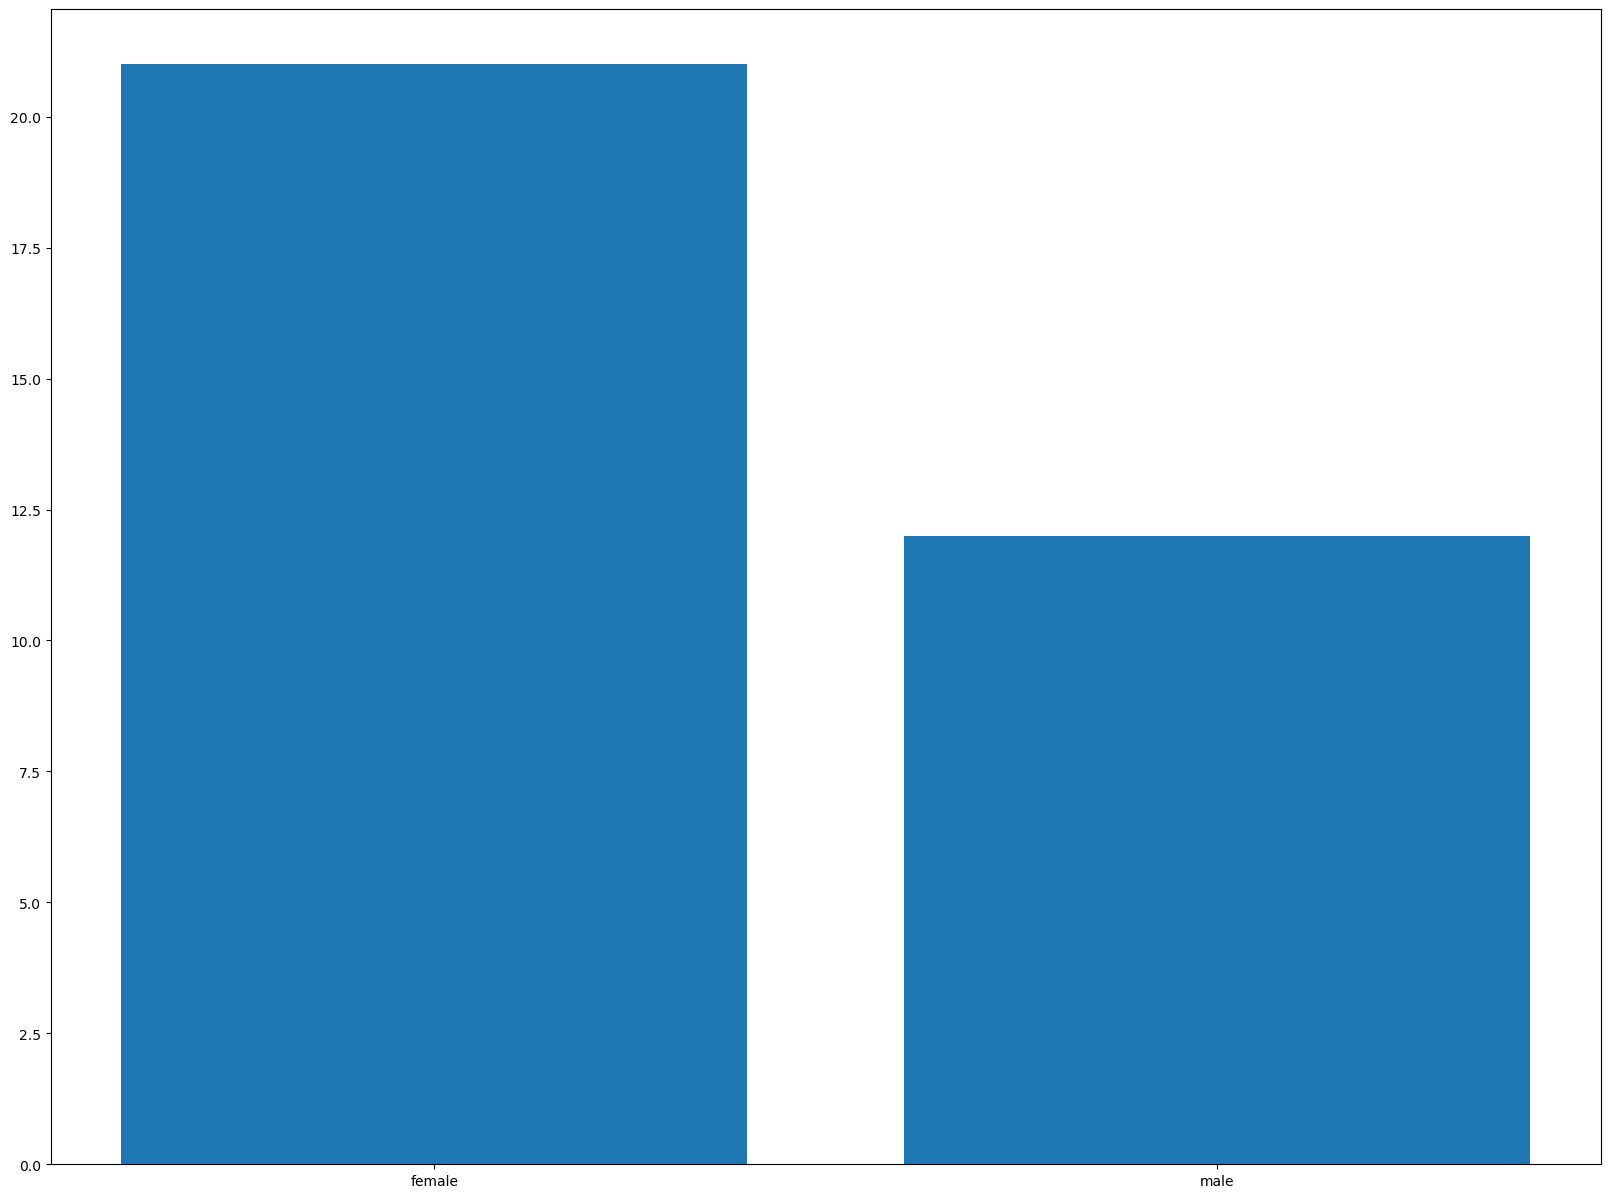

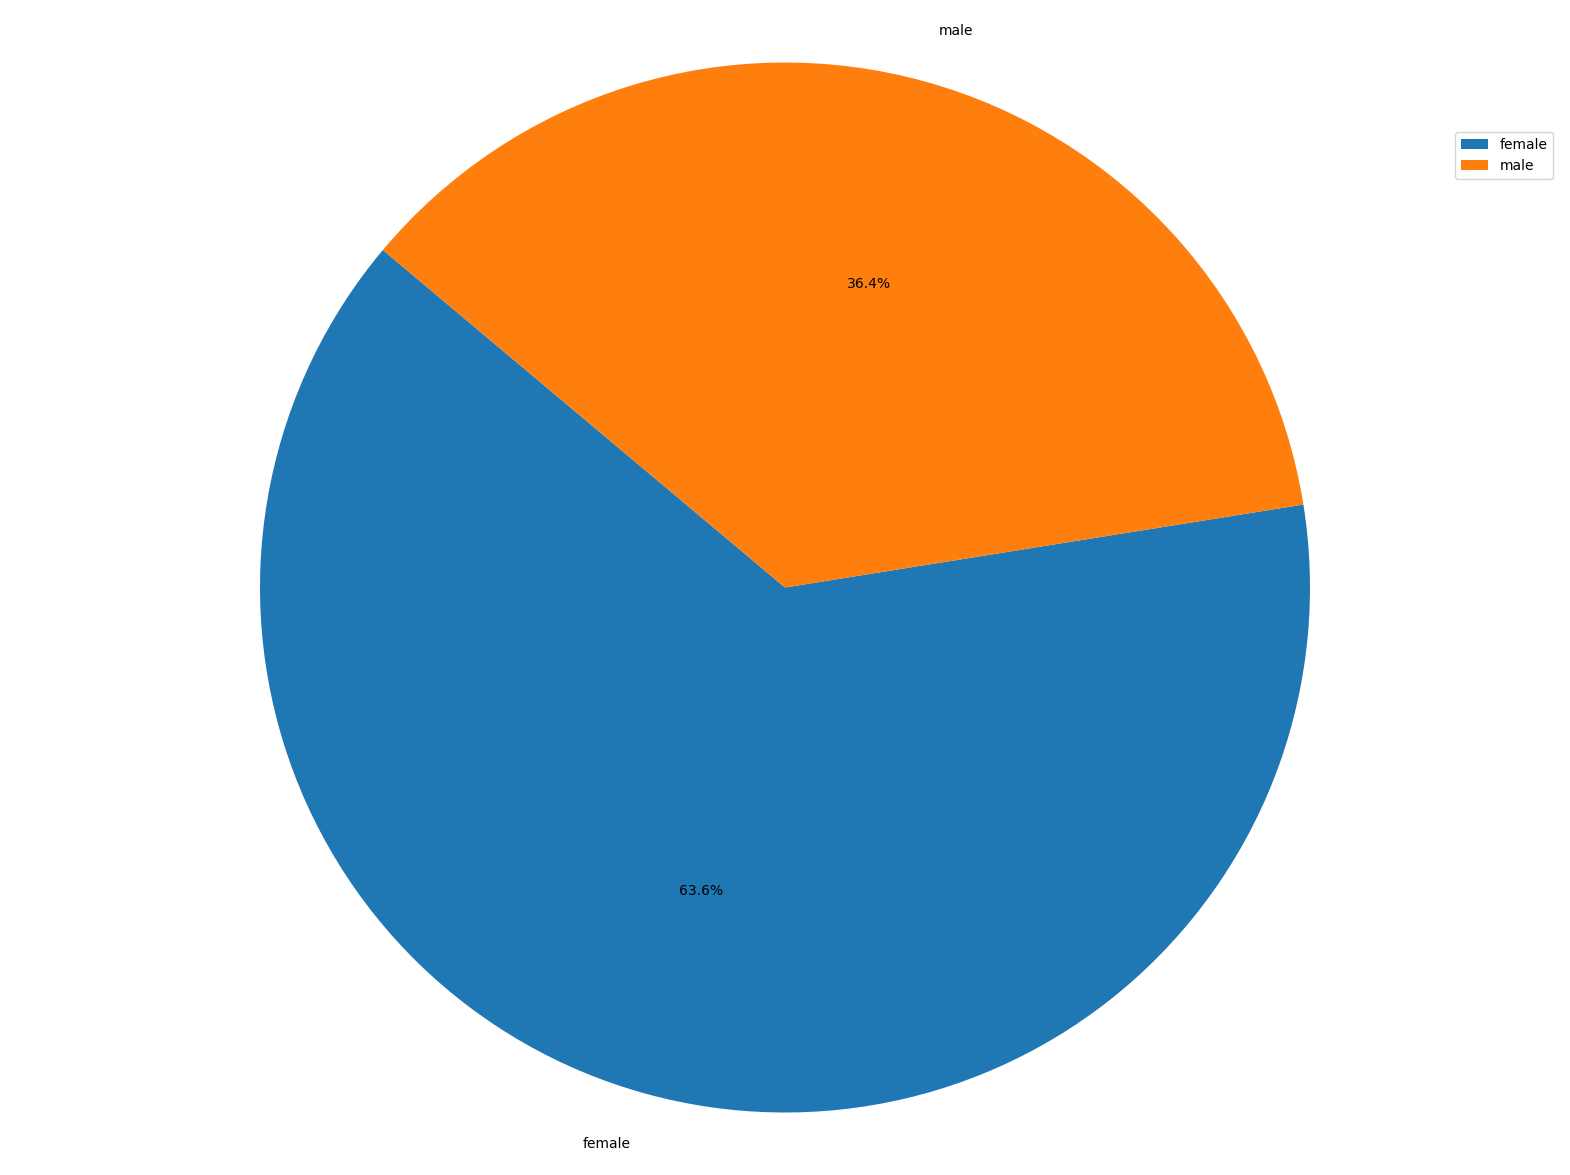

sex,count
str,u32
"""female""",21
"""male""",12


In [206]:
# 1.2 how is the split in sex
grouped_by_sex = df.groupby('sex').count()

barchart(grouped_by_sex['sex'], grouped_by_sex['count'], figsize=figsize)
piechart(grouped_by_sex['sex'], grouped_by_sex['count'], figsize=figsize)

grouped_by_sex.head()

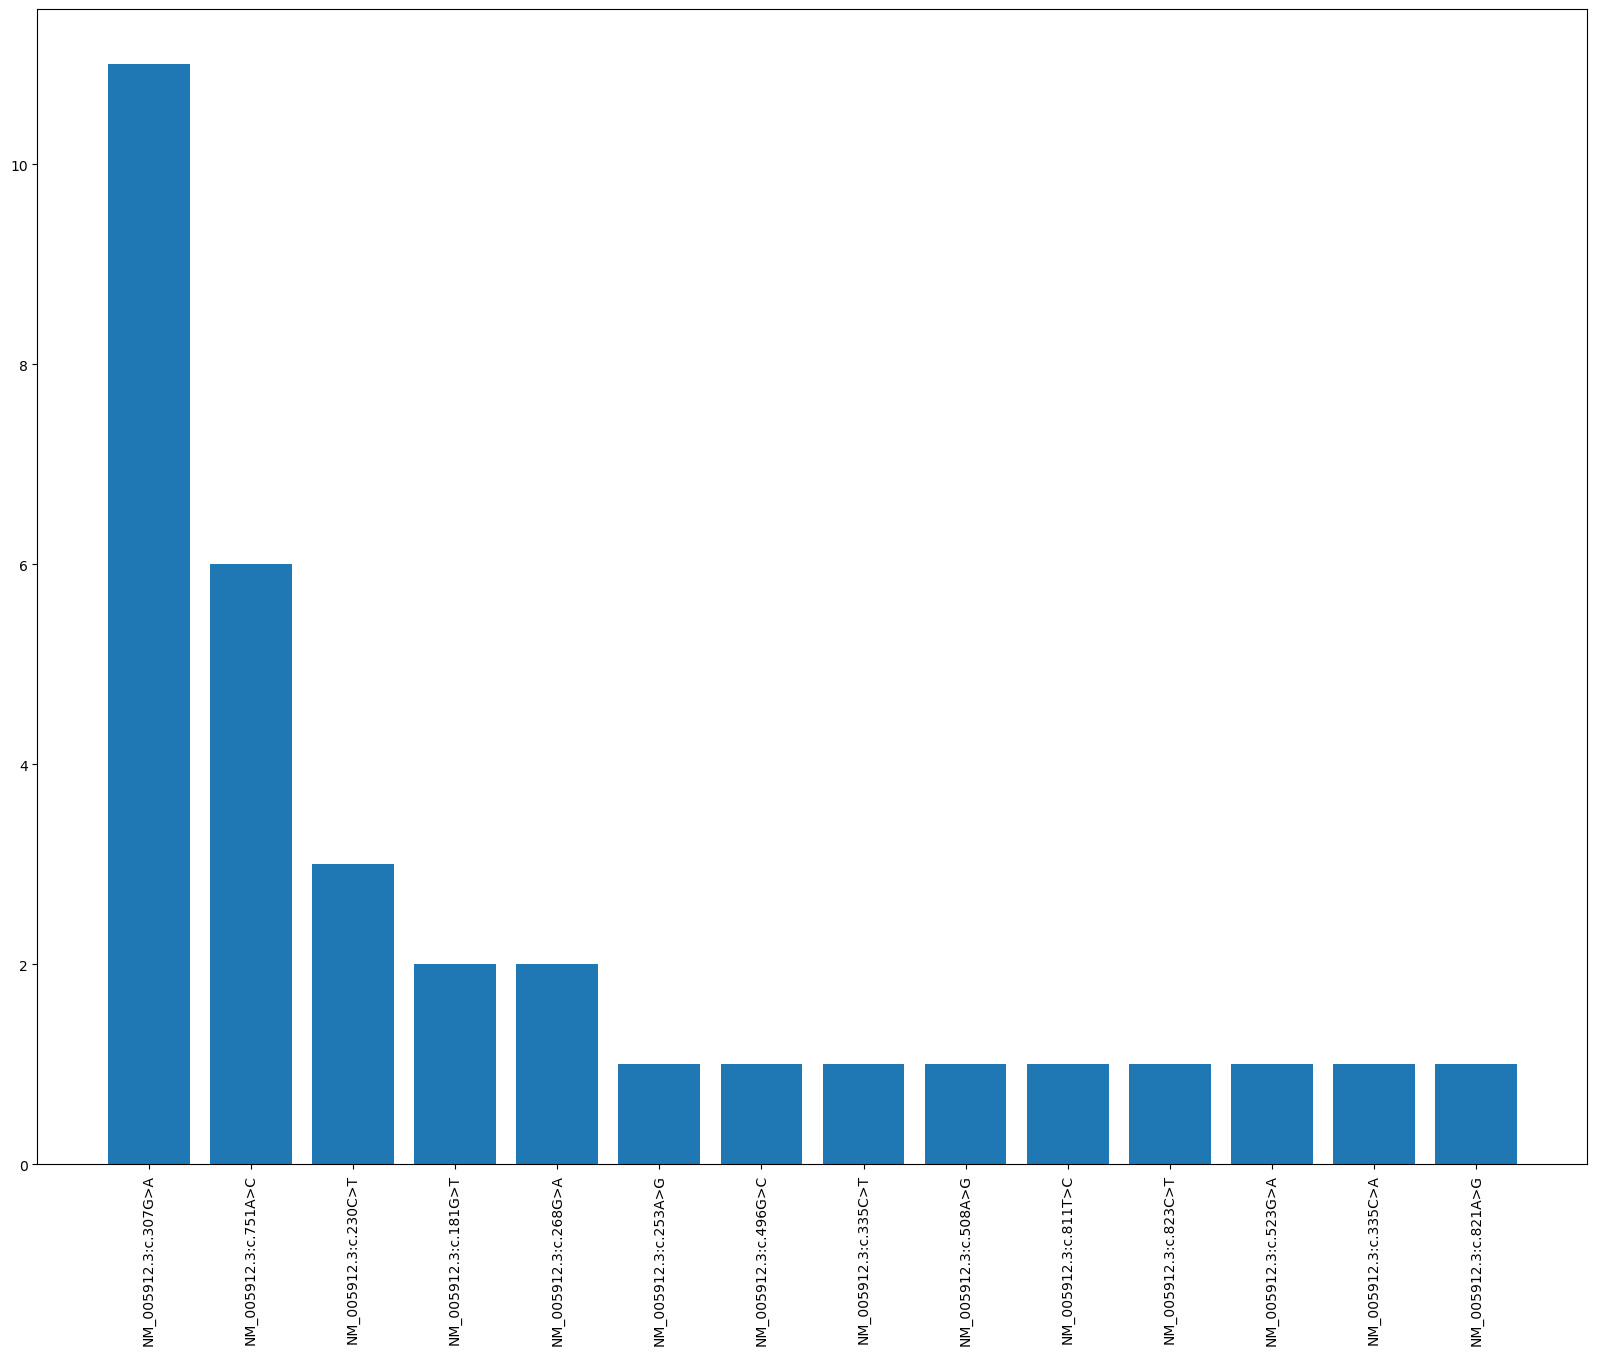

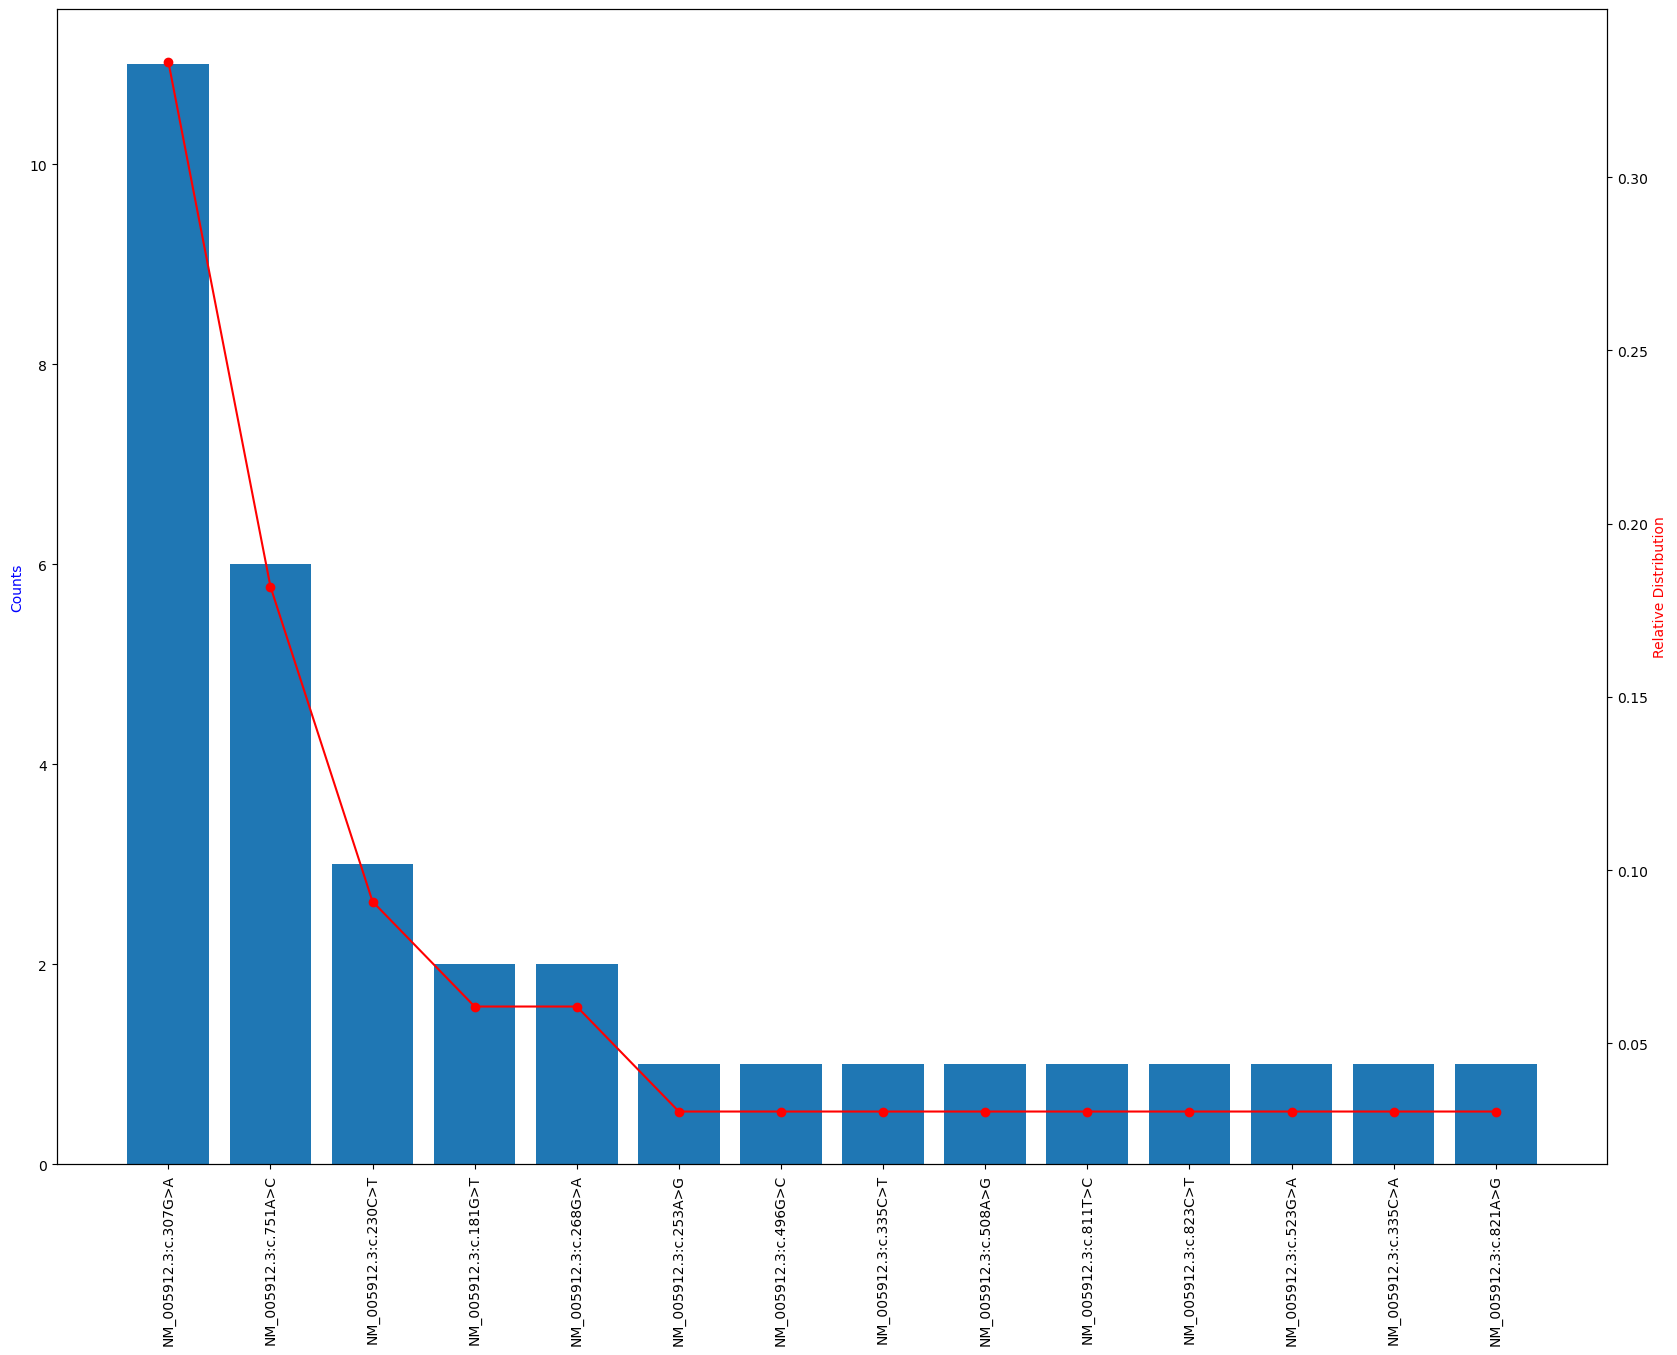

c_hgvs,count
str,u32
"""NM_005912.3:c.…",11
"""NM_005912.3:c.…",6
"""NM_005912.3:c.…",3
"""NM_005912.3:c.…",2
"""NM_005912.3:c.…",2
"""NM_005912.3:c.…",1
"""NM_005912.3:c.…",1
"""NM_005912.3:c.…",1
"""NM_005912.3:c.…",1


In [207]:
# 2. Distribution of c_hgvs mutations?
grouped_by_c_hgvs = df.groupby('c_hgvs').count().sort('count', descending=True)
num_c_hgvs = grouped_by_c_hgvs.height

barchart(grouped_by_c_hgvs['c_hgvs'], grouped_by_c_hgvs['count'], figsize=figsize, x_tick_rotation='vertical')

barchart_relative_distribution(grouped_by_c_hgvs['c_hgvs'], grouped_by_c_hgvs['count'], figsize=figsize, x_tick_rotation='vertical')
# todo: add label percent to each dot

grouped_by_c_hgvs.head(50)

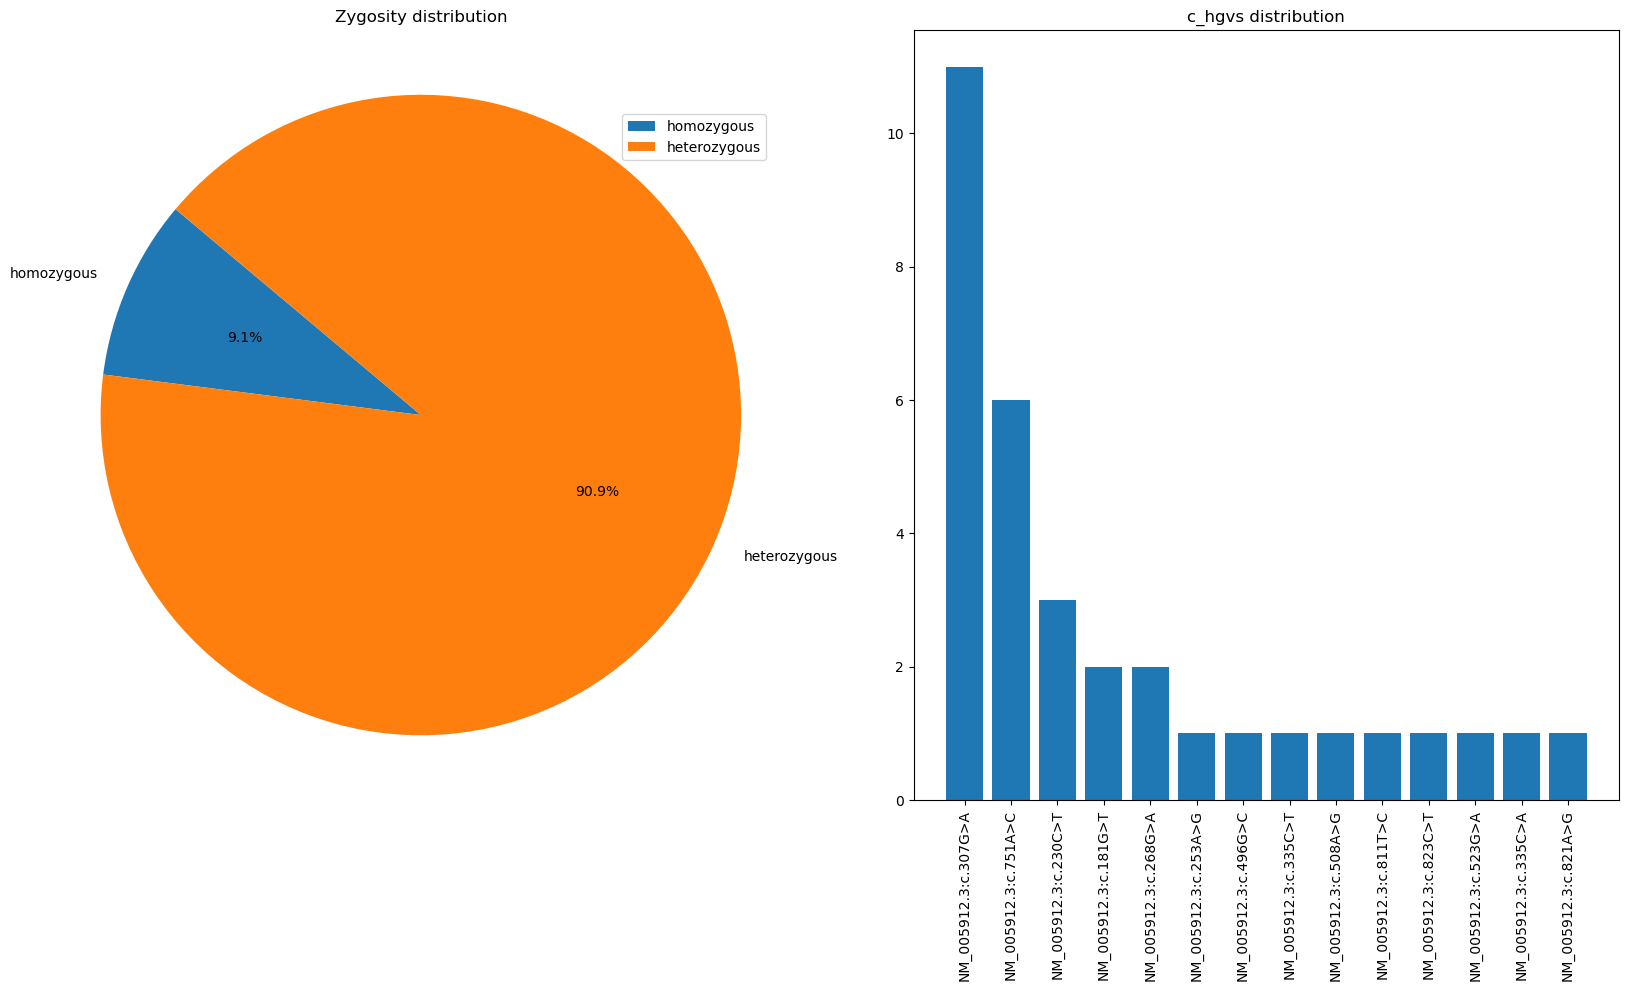

In [208]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

piechart_subplot(ax1, grouped_by_zygosity['zygosity'], grouped_by_zygosity['count'], 'Zygosity distribution',)
barchart_subplot(ax2, grouped_by_c_hgvs['c_hgvs'], grouped_by_c_hgvs['count'], 'c_hgvs distribution', x_tick_rotation='vertical')
plt.show()

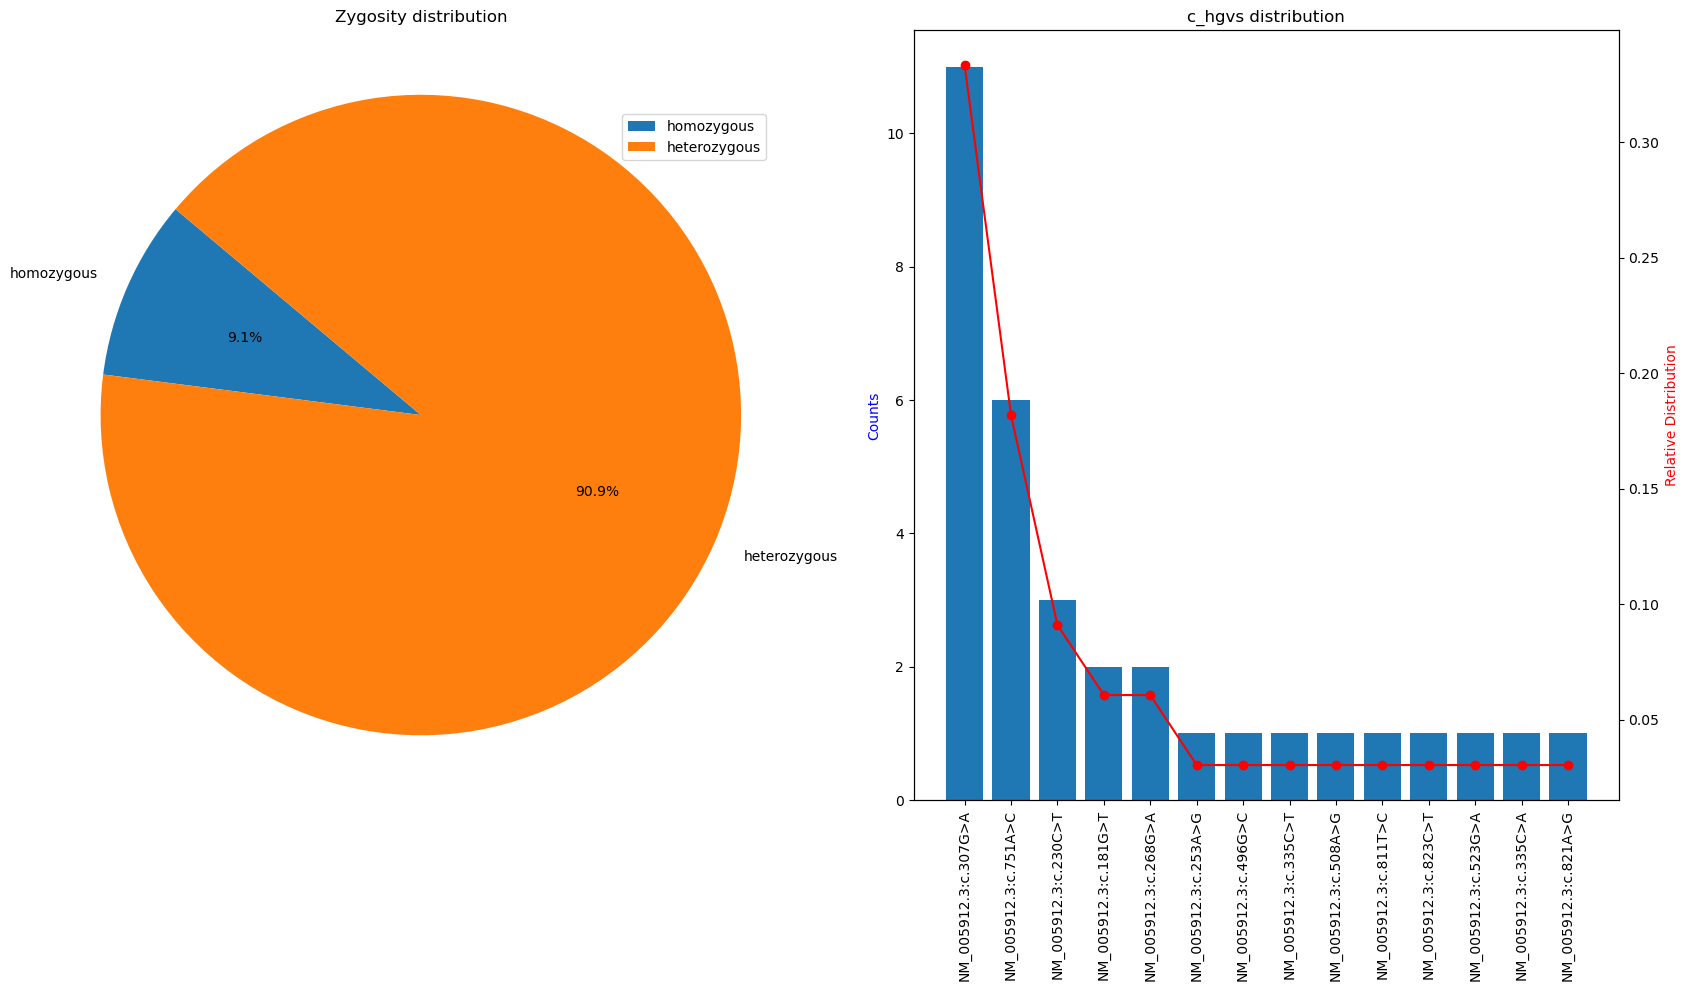

In [209]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
piechart_subplot(ax1, grouped_by_zygosity['zygosity'], grouped_by_zygosity['count'], 'Zygosity distribution',)
barchart_relative_distribution_subplot(ax2, grouped_by_c_hgvs['c_hgvs'], grouped_by_c_hgvs['count'], 'c_hgvs distribution', x_tick_rotation='vertical')
plt.show()

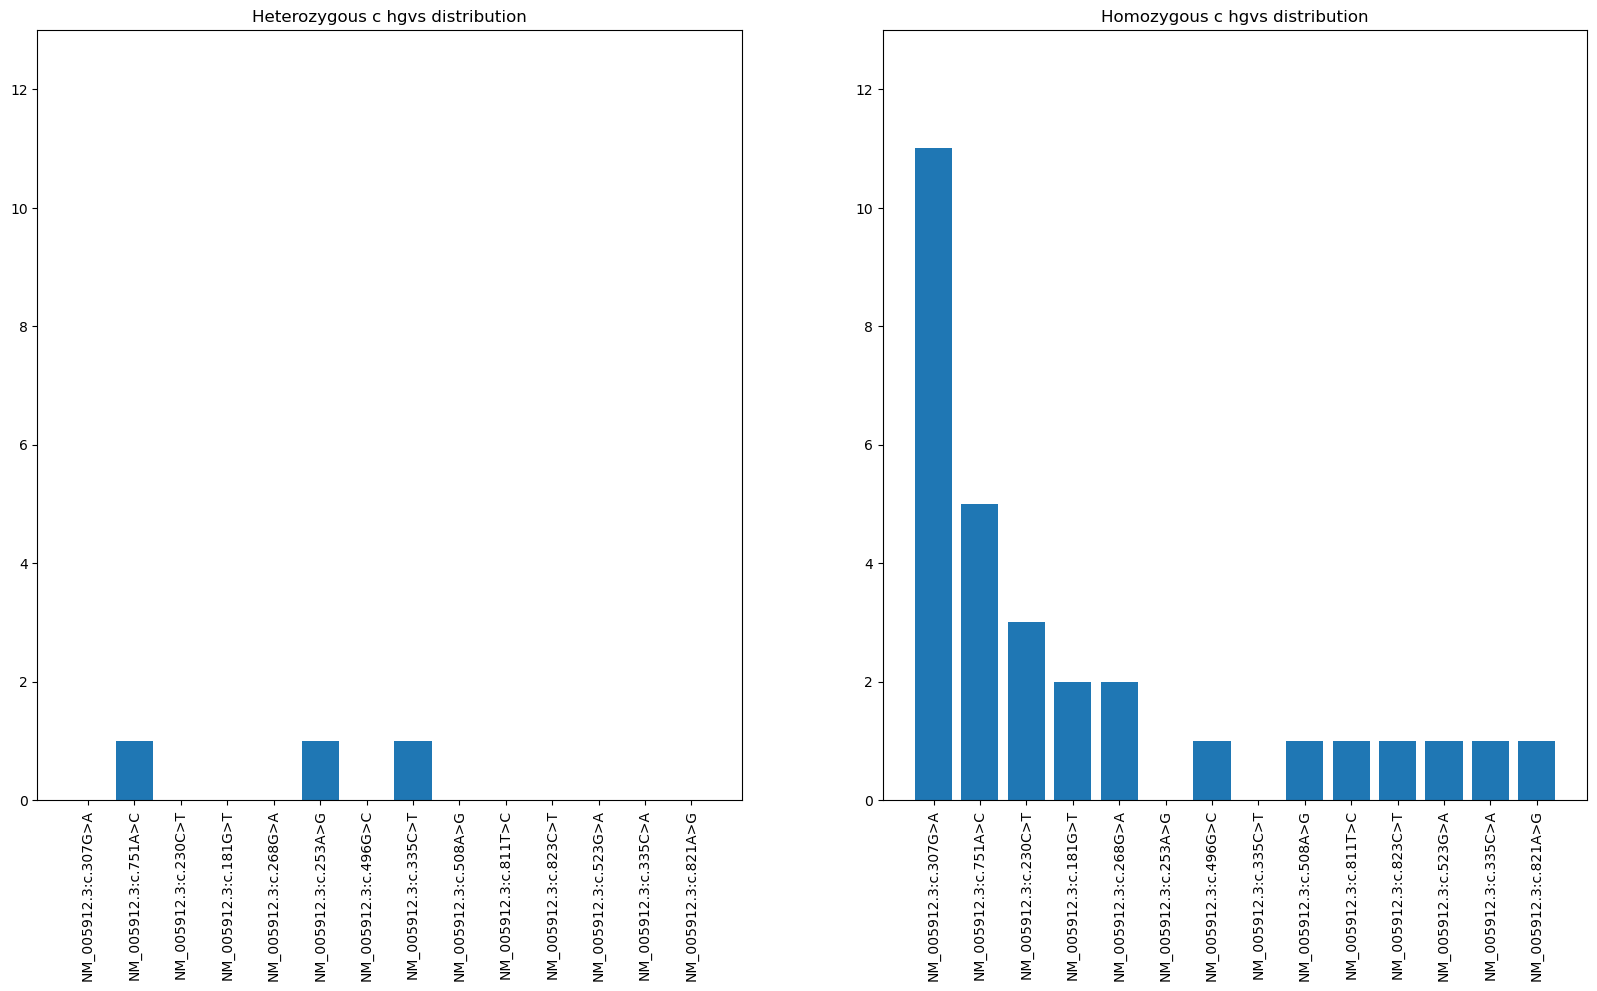

In [210]:
from ERKER2Phenopackets.src.utils.polars_utils import contingency_table

# 3. What if we split the distribution of c_hgvs mutations by zygosity?
# barchart_3d(df, 'zygosity', 'c_hgvs', figsize=figsize, grouped_by_col1=grouped_by_zygosity, grouped_by_col2=grouped_by_c_hgvs) # not really useful

ct_zygosity_c_hgvs = contingency_table(df, 'zygosity', 'c_hgvs', grouped_by_zygosity['zygosity'], grouped_by_c_hgvs['c_hgvs'])
heterozygous_c_hgvs_frquency, homozygous_c_hgvs_frquency = ct_zygosity_c_hgvs[0], ct_zygosity_c_hgvs[1]
y_lim = int(np.max(ct_zygosity_c_hgvs) * 1.1) + 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
barchart_subplot(ax1, grouped_by_c_hgvs['c_hgvs'], heterozygous_c_hgvs_frquency, 'Heterozygous c hgvs distribution', x_tick_rotation='vertical', y_min=0, y_max=y_lim)
barchart_subplot(ax2, grouped_by_c_hgvs['c_hgvs'], homozygous_c_hgvs_frquency, 'Homozygous c hgvs distribution', x_tick_rotation='vertical', y_min=0, y_max=y_lim)
plt.show()

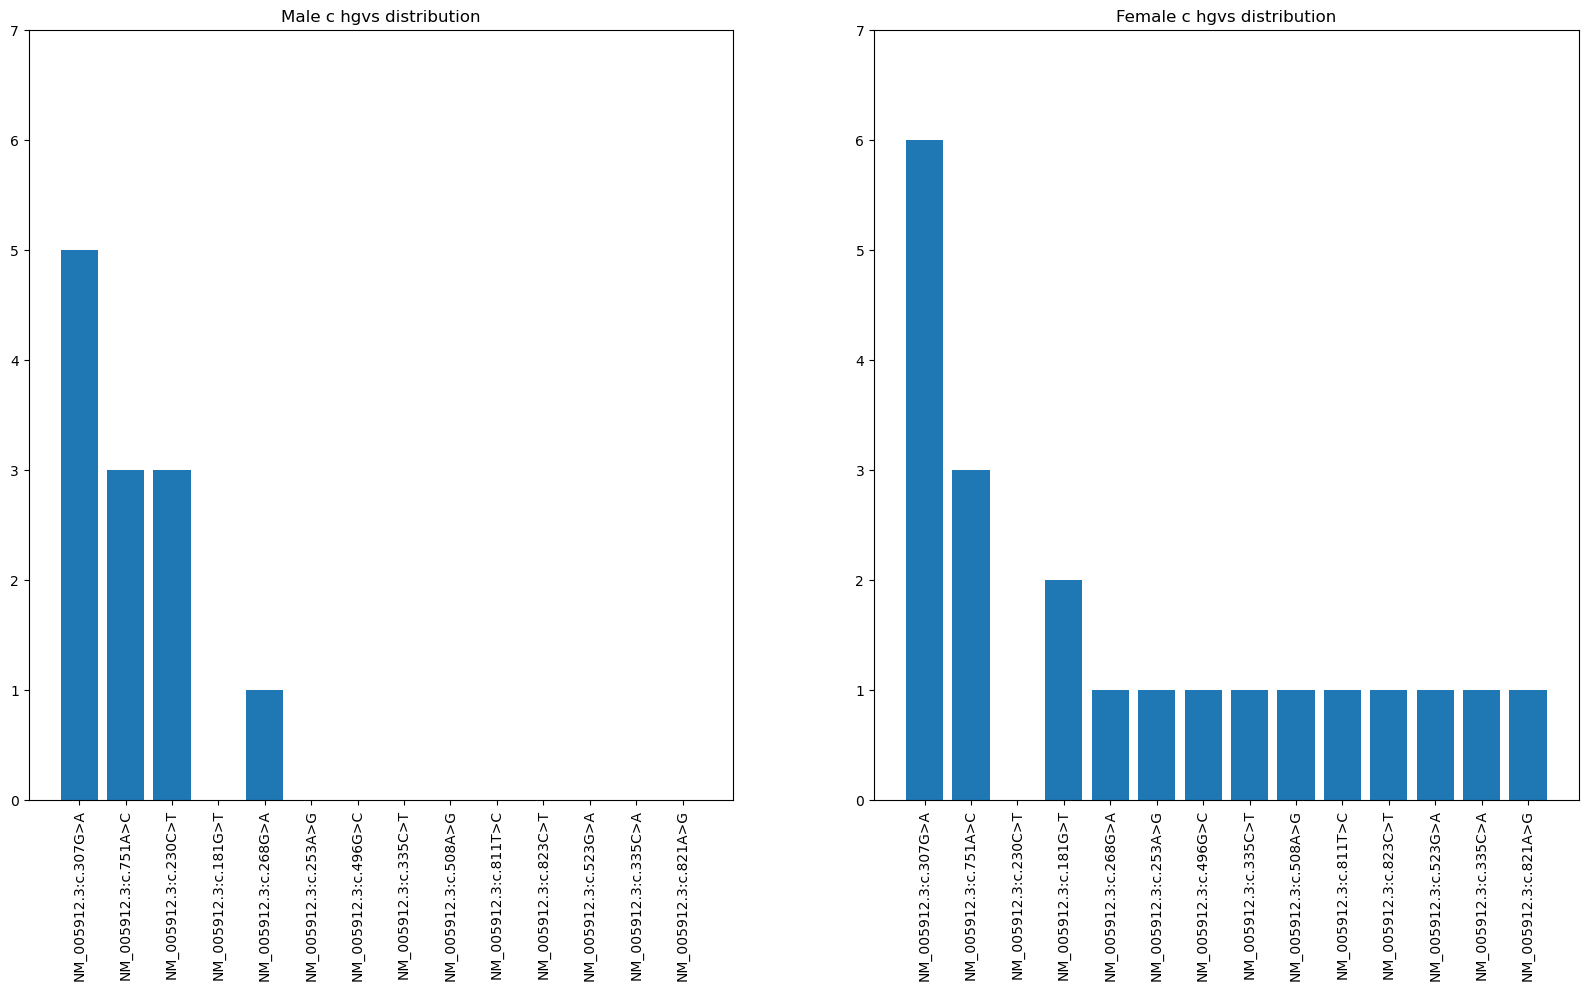

In [211]:
ct_sex_c_hgvs = contingency_table(df, 'sex', 'c_hgvs', ('male', 'female'), grouped_by_c_hgvs['c_hgvs'])
male_c_hgvs_frquency, female_c_hgvs_frquency = ct_sex_c_hgvs[0], ct_sex_c_hgvs[1]
y_lim = int(np.max(ct_sex_c_hgvs) * 1.1) + 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
barchart_subplot(ax1, grouped_by_c_hgvs['c_hgvs'], male_c_hgvs_frquency, 'Male c hgvs distribution', x_tick_rotation='vertical', y_min=0, y_max=y_lim)
barchart_subplot(ax2, grouped_by_c_hgvs['c_hgvs'], female_c_hgvs_frquency, 'Female c hgvs distribution', x_tick_rotation='vertical', y_min=0, y_max=y_lim)
plt.show()

In [212]:
from ERKER2Phenopackets.src.utils.polars_utils import melt_groupby_count, sort_columns

# 4. Distribution of obesity classes?
# 4.1 count appearance of obesity classes/ hpo terms at each of the 3 inspections
result = melt_groupby_count(df, columns=['obesity_class0', 'obesity_class1', 'obesity_class2']).sort(by='value')

result = sort_columns(result, ['value'])

result.head(50)

value,obesity_class0,obesity_class1,obesity_class2
str,u32,u32,u32
null,0,5,21
"""Class I obesit…",0,4,0
"""Class II obesi…",1,1,0
"""Growth abnorma…",5,16,9
"""Obesity""",27,5,2
"""Overweight""",0,2,1


In [213]:
result = melt_groupby_count(df, columns=['obesity_class_hpo0', 'obesity_class_hpo1', 'obesity_class_hpo2']).sort(by='value')

result = sort_columns(result, ['value'])

result.head(50)

value,obesity_class_hpo0,obesity_class_hpo1,obesity_class_hpo2
str,u32,u32,u32
null,5,5,21
"""HP:0001507""",0,16,9
"""HP:0001513""",27,5,2
"""HP:0025499""",0,4,0
"""HP:0025500""",1,1,0
"""HP:0025502""",0,2,1


In [214]:
# 5. What if we split the distribution of obesity classes by zygosity?

In [215]:
# 6. What if we split the distribution of obesity classes by c_hgvs mutation?

In [216]:
# 7. What if we split the distribution of obesity classes by c_hgvs mutation and zygosity?

In [217]:
# 8. How long does it take for a person to develop the different obesity classes based on their mutation?

In [218]:
# 9. Most severe mutation?